# Needs: 
- record results (and compare) from multiple pipelines
- implement new component seamlessly

In [2]:
!pip install mlflow

In [3]:
# The data set used in this example is from http://archive.ics.uci.edu/ml/datasets/Wine+Quality
# P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
# Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

import mlflow
import mlflow.sklearn

import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2



if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    np.random.seed(40)

    # Read the wine-quality csv file from the URL
    csv_url =\
        'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(csv_url, sep=';')
    except Exception as e:
        logger.exception(
            "Unable to download training & test CSV, check your internet connection. Error: %s", e)

    # Split the data into training and test sets. (0.75, 0.25) split.
    train, test = train_test_split(data)

    # The predicted column is "quality" which is a scalar from [3, 9]
    train_x = train.drop(["quality"], axis=1)
    test_x = test.drop(["quality"], axis=1)
    train_y = train[["quality"]]
    test_y = test[["quality"]]

    alpha =  0.15
    l1_ratio =  0.3

    with mlflow.start_run():
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        lr.fit(train_x, train_y)

        predicted_qualities = lr.predict(test_x)

        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

        print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        mlflow.sklearn.log_model(lr, "model")

Elasticnet model (alpha=0.150000, l1_ratio=0.300000):
  RMSE: 0.7322681693148748
  MAE: 0.5630381252640116
  R2: 0.2402441687623419


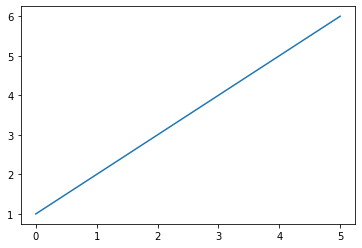

In [16]:
import matplotlib.pyplot as plt
import numpy as np

params = ["ANN","CNN","LDA"]
metrics = [param+"_mse" for param in params]


with mlflow.start_run():
    mlflow.log_param("type",str(params))
    for param_id, param in enumerate(params):
        mlflow.log_metric(key=metrics[param_id],value=float(np.random.randn(1)))
        mlflow.set_tag("TYPE", "ANN")
        
    fig = plt.figure()
    plt.plot([1,2,3,4,5,6])
    filename = "hello.png"
    fig.savefig(filename)
    mlflow.log_artifact(filename,"PERF")